# Анализ поведения пользователей в мобильном приложении

От продуктового менеджера мобильного приложения «Ненужные вещи» поступила задача проанализировать поведение пользователей. В приложении пользователи продают свои ненужные вещи, размещая их на доске объявлений. Результаты исследования помогут продуктовой команде выделить основные сценарии использования приложения и оценить, какие фичи работают.

**Задача исследования**

Проанализировать целевое и вспомогательные события, совершаемые пользователями мобильного приложения.

**Ход исследования**

Для проведения исследования доступны следующие данные:

* data_dataset.csv — логи пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.
* data_sources.csv — данные об источнике трафика пользователей мобильного приложения.

Перед решением задачи исследования понадобится обзор данных. Затем, на этапе предобработки, поищем возможность исправить самые критичные ошибки данных.

Для анализа влияние событий на совершение целевого события потребуется:

* Выделить события, которые часто совершают пользователи вместе с целевым событием.
* Проанализировать, часто ли эти события бывают самостоятельными событиями пользователя или они составляют воронку.
* Проанализировать, за какое время до совершения целевого события совершаются вспомогательные события.

Проверим гипотезы:

* Конверсия в просмотры контактов различается пользователей, которые совершают действия tips_show и tips_click, и тех, которые совершают только действие tips_show.
* Конверсия в просмотры контактов различается в зависимости от источника.

**Этапы исследования**

1. Обзор данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Анализ влияния событий на совершение целевого события
5. Статистический анализ данных
6. Выводы

## Обзор данных
Составим первое впечатление о входных данных.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# Читаем файлы с данными и сохраняем их в датафреймы
dataset, sourсes = (
    pd.read_csv('data_dataset.csv'), # логи
    pd.read_csv('data_sourсes.csv')  # источники
)

In [3]:
# Определяем функцию для обзора данных датафрейма
def get_overview(df):
    '''
    Принимает датафрейм, возвращает первые 5 строк,
    общую информацию, обзор числовых и строковых значений
    '''
    display(df.head())
    print(df.info())
    print(df.describe(include='all'))

In [4]:
# Обзора данных датафрейма dataset
get_overview(dataset)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
                        event.time event.name  \
count                        74197      74197   
unique                       74197         16   
top     2019-10-07 00:00:00.431357  tips_show   
freq                             1      40055   

                                     user.id  
count                                  74197  
unique                                  4293  
top     cb36854f-570a-41f4-baa8-36680b396370  
freq                                     478  


В таблице 3 столбца, 74 197 строк.

Согласно документации к данным:

* `event.time` — время совершения
* `user.id` — идентификатор пользователя
* `event.name` — действие пользователя

В столбцах отмечены нарушения стиля — использование точки для разделения слов.

Отмечено несоответствие типа данных документации:

* `event.time` строка `object`, по документации дата и время → `datetime`

Пропусков значений нет.

* В логах 16 уникальных типов событий, наиболее частое — *tips_show* (40 055 событий).
* В логах 4293 уникальных пользователя.
* Отмечен случай очень активного использования приложения — пользователь с 478 событиями.

Проверим все типы событий.

In [5]:
# Выведем значения event.name
dataset['event.name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event.name, dtype: int64

Согласно документации к данным:

* `tips_show` — увидел рекомендованные объявления
* `photos_show` — просмотрел фотографий в объявлении
* `advert_open` — открыл карточки объявления
* `contacts_show` и `show_contacts` — посмотрел номер телефона
* `map` — открыл карту объявлений
* `search_1` - `search_7` — разные действия, связанные с поиском по сайту
* `favorites_add` — добавил объявление в избранное
* `tips_click` — кликнул по рекомендованному объявлению
* `contacts_call` — позвонил по номеру из объявления

Поскольку у нас нет сведений, чем отличаются события `search_1` - `search_7`, их следует объединить в одну категорию `search`.

Видно, что `contacts_show` и `show_contacts` — одно и то же событие, вероятно, различное название появилось из-за сбора данных из разных источников. Эти события объединим в одну категорию `contacts_show`.

In [6]:
# Обзора данных датафрейма sourсes
get_overview(sourсes)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None
                                      userId  source
count                                   4293    4293
unique                                  4293       3
top     020292ab-89bc-4156-9acf-68bc2783f894  yandex
freq                                       1    1934


В таблице 2 столбца, 4293 строк.

Согласно документации к данным:

* userId — идентификатор пользователя
* source — источник, с которого пользователь установил приложение

В столбце отмечено нарушения стиля — использование CamelCase.

Пропусков значений нет.

* В таблице 3 уникальных источника трафика, наиболее частый — *yandex* (указан для 1934 пользователей).
* В таблице 4293 уникальных пользователя, что совпадает с количеством уникальных пользователей таблицы *dataset*.

Проверим все источники.

In [7]:
# Выведем значения source
sourсes['source'].value_counts()

yandex    1934
other     1230
google    1129
Name: source, dtype: int64

Среди источников встречаются поисковые системы Yandex, Google и прочие источники.

**Вывод**
<div style="background-color: #FBD603; width: 48px; height: 5px">&nbsp;</div>

Как и следовало из сопроводительной документации, мы располагаем данными о событиях, совершенных пользователями мобильного приложения и источниках привлечения пользователей.

В столбцах отмечены нарушения стиля. Данные столбца `event.time` следует привести к типу данных `datetime`.

Предварительно мы отметили, что в датасете 16 уникальных типов событий (наиболее частое — *tips_show*), 3 уникальных источника трафика (наиболее частый — *yandex*) и 4293 уникальных пользователя.

Число уникальных пользователей совпадает в обеих таблицах, скорее всего, с объединением таблиц проблем возникнуть не должно. Одинаковые по смыслу события объединим в категории `search` и `contacts_show`.

## Предобработка данных
Исправим именование столбцов. Объединим данные. Заменим тип данных `event.time`. Объединим события *search* и *contacts_show*. Проверим данные на дубликаты.

### Стиль заголовков
Заменим в названиях столбцов точки на подчеркивания и уберем CamelCase.

In [8]:
# Заменяем точки на подчеркивания
dataset.columns = [x.replace('.', '_') for x in dataset.columns]

# Переименовываем столбец с CamelCase
sourсes.rename(columns={'userId': 'user_id'}, inplace=True)

Стиль названий столбцов в датафреймах приведен к корректному.

### Объединение данных
Добавим информацию об источнике из датафрейма *sourсes* в датафрейм *dataset*.

In [9]:
# Создадим датафрейм df с объединенными данными
df = dataset.merge(sourсes, on='user_id', how='left')

# Проверим получившийся датафрейм, выведем первые 5 строк
df.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


Исходные данные сведены в один датафрейм.

### Замена типа данных
Заменим тип данных `event_time` на тип данных `datetime` с помощью `pandas.to_datetime`.

In [10]:
# Изменим тип данных на datetime
df['event_time'] = pd.to_datetime(df['event_time'])

Тип данных столбца `event_time` приведен к корректному.

### Объединение событий
Объединим события `search_1` - `search_7` и `contacts_show` / `show_contacts`.

In [11]:
# Заменяем события search_1-search_7 на search
df.loc[df['event_name'].str.contains('search'), 'event_name'] = 'search'

# Заменяем события show_contacts на contacts_show
df.loc[df['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'

# Проверяем значения event_name
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

Одинаковые по смыслу события объединены в категории `search` и `contacts_show`.

### Обработка дубликатов
Проверим данные на явные строковые дубликаты.

In [12]:
# Проверим дубликаты
print('Дубликаты:', df.duplicated().sum())

Дубликаты: 0


Явные строковые дубликаты отсутствуют.

Проверим, как связно наличие дубликатов с точностью времени регистрации события — как отстоят друг от друга одинаковые события одних и тех же пользователей.

In [13]:
# Округлим время события до миллисекунд и проверим заново
duplicates = df.copy()
duplicates['event_time'] = duplicates['event_time'].dt.round('ms')
print(
    'Дубликаты при округлении до миллисекунд:',
    duplicates.duplicated().sum()
)

# Округлим время события до секунд и проверим заново
duplicates['event_time'] = duplicates['event_time'].dt.round('S')
print(
    'Дубликаты при округлении до секунд:',
    duplicates.duplicated().sum()
)

# Выведем несколько примеров дубликатов
duplicates.loc[duplicates.duplicated(keep=False)].tail(10)

Дубликаты при округлении до миллисекунд: 44
Дубликаты при округлении до секунд: 1189


,event_time,event_name,user_id,source
73010,2019-11-03 18:02:20,photos_show,6e623c43-e219-4c27-bc29-5180d9250f8d,other
73011,2019-11-03 18:02:20,photos_show,6e623c43-e219-4c27-bc29-5180d9250f8d,other
73426,2019-11-03 20:09:47,tips_show,a0944ccf-5813-427a-966e-b146d4e9adbc,google
73427,2019-11-03 20:09:47,tips_show,a0944ccf-5813-427a-966e-b146d4e9adbc,google
73677,2019-11-03 21:10:40,photos_show,06edf71c-b725-47dc-acfe-0c78f079fe8f,yandex
73678,2019-11-03 21:10:40,photos_show,06edf71c-b725-47dc-acfe-0c78f079fe8f,yandex
73838,2019-11-03 21:45:22,photos_show,1af9ffcd-2c77-4de0-9d35-3ff30604c9bd,google
73839,2019-11-03 21:45:22,photos_show,1af9ffcd-2c77-4de0-9d35-3ff30604c9bd,google
74027,2019-11-03 22:41:01,tips_show,16a5371c-152f-48d8-86fe-5636a931316b,yandex
74028,2019-11-03 22:41:01,tips_show,16a5371c-152f-48d8-86fe-5636a931316b,yandex


При округлении до миллисекунд появляется 44 дубликата, а при округлении до секунд — 1189 дубликатов.

Если появление дубликатов при округлении до миллисекунд можно считать технической ошибкой (вероятность за миллисекунду выполнить два действия крайне мала), то дубликаты при округлении до секунд однозначно интерпретировать сложно. Возникновение таких дубликатов может быть связано как с технической ошибкой (повторная регистрация события), так и быть вполне правдоподобным явлением (случайное повторное нажатие).

В рамках исследования время события решено не округлять, дубликаты, возникающие при округлении, не удалять. Поскольку основные метрики и проверки выполняются по уникальным пользователям, такие дубли не окажут влияния на результат.

**Вывод**
<div style="background-color: #FBD603; width: 48px; height: 5px">&nbsp;</div>

На этапе предобработки данных мы исправили стиль заголовков и тип данных столбца `event_time`.

Исходные данные были объединены в один датафрейм.

Мы обнаружили аномалию в данных — дубликаты, возникающие при округлении времени события до миллисекунд и секунд. Не имея дополнительной информации о регистрации событий, невозможно однозначно утверждать, является ли она ошибкой в данных. Решено время события не округлять, потенциальные дубликаты не удалять, так как они не оказали бы влияния на результаты исследования.

## Исследовательский анализ данных
Изучим события и пользователей в логах, период наблюдения. Выделим и изучим пользовательские сессии. Получим пользовательские профили. Рассчитаем DAU, retention rate и конверсию.

### События и пользователи в логах
Узнаем, сколько всего событий, пользователей в логах, а также сколько в среднем событий приходится на пользователя.

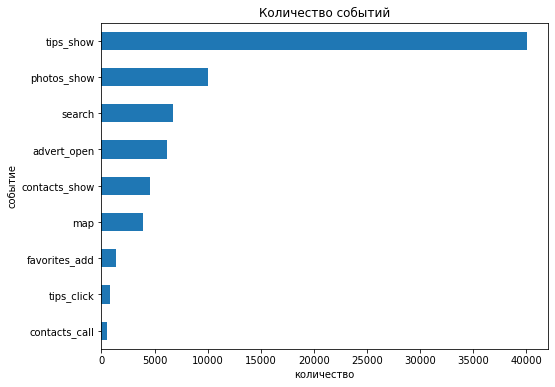

In [14]:
# Распределение событий по типам
(
    df
    .groupby('event_name')
    .agg({'user_id': 'count'})
    .sort_values(by='user_id', ascending=True)
    .plot(kind='barh', figsize=(8, 6), legend=False)
)
plt.title('Количество событий')
plt.xlabel('количество')
plt.ylabel('событие')
plt.show()

Наиболее частое событие — *tips_show* (увидел рекомендованные объявления). Исходя из документации, это событие по умолчанию, пользователю всегда показываются рекомендованные объявления.

Из пользовательских взаимодействий наиболее частыми являются *photos_show* (просмотрел фотографий в объявлении), *search* (действия, связанные с поиском по сайту), *advert_open* (открыл карточки объявления), contacts_show (посмотрел номер телефона) и *map* (открыл карту объявлений).

Среди редких пользовательских взаимодействий *favorites_add* (добавил объявление в избранное), *tips_click* (кликнул по рекомендованному объявлению) и *contacts_call* (позвонил по номеру из объявления).

In [15]:
# Количество пользователей
print(
    'Уникальных пользователей:',
    df['user_id'].nunique()
)

Уникальных пользователей: 4293


В датасете представлены данные 4293 уникальных пользователей.

In [16]:
# Количество событий на пользователя
(
    df
    .groupby('user_id')
    .agg({'event_name': 'count'})
    .describe()
)

,event_name
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,478.000000


В среднем на одного уникального пользователя приходится 17 событий, медианное значение — 9 событий. На среднее значение сильно влияют выбросы (пользователи, с очень большим числом событий).

### Период наблюдения
Оценим, данными за какой период мы располагаем, а также полноту данных.

In [17]:
# Минимальная и максимальная даты события
print(
    'Минимальная дата:',
    df['event_time'].min().round(freq='S'),
    '\nМаксимальная дата:',
    df['event_time'].max().round(freq='S')
)

Минимальная дата: 2019-10-07 00:00:00 
Максимальная дата: 2019-11-03 23:58:13


В логах представлены данные о событиях за период с 7 октября 2019 по 3 ноября 2019. Это 4 полные недели, начиная с понедельника.

Посмотрим, как распределены события по дате.

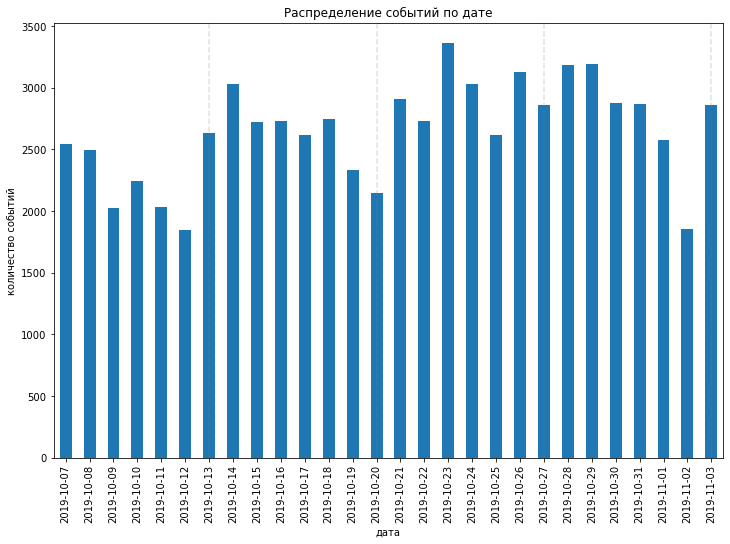

In [18]:
# Выделим день в отдельный столбец
df['event_date'] = df['event_time'].dt.date

# График распределения событий по дате
(
    df
    .groupby('event_date')
    .agg({'event_name': 'count'})
    .plot(kind='bar', figsize=(12, 8), legend=False)
)
for i in range(len(df['event_date'].unique())):
    if i in [6, 13, 20, 27]:
        plt.axvline(x=i, color='gray', alpha=0.25, linestyle='--')
plt.title('Распределение событий по дате')
plt.xlabel('дата')
plt.ylabel('количество событий')
plt.show()

Судя по графику, данные за рассматриваемый период полные.

На графике видно, что количество событий различается по дням недели (конец недели отмечен пунктирной линией). Наибольшее число событий обычно совершаются в понедельник и вторник, к выходным активность пользователей снижается. Можно отметить растущий тренд — от недели к неделе растет число событий.

### Пользовательские сессий
Определим величину таймаута. Выделим пользовательские сессии. Рассчитаем и визуализируем число сессий на пользователя.

Для последующего выделения пользовательских сессий нужно определиться со значением таймаута — времени, по которому мы разделим 2 последовательных события одного пользователя на разные сессии.

count                        69904
mean     0 days 03:53:01.169952121
std      1 days 01:32:57.259354294
min         0 days 00:00:00.000001
25%      0 days 00:00:23.594245250
50%         0 days 00:01:10.535313
75%      0 days 00:03:00.300498750
max        26 days 13:49:54.853516
Name: event_time, dtype: object


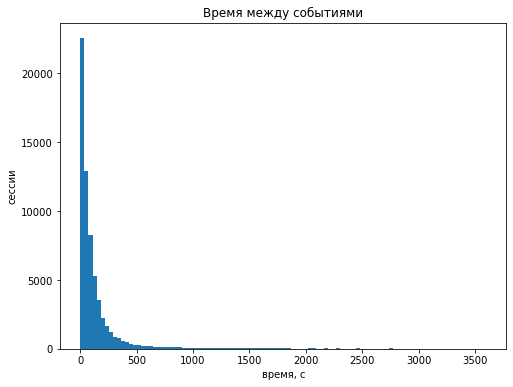

In [19]:
# Рассчитаем разницу времени между событиями
# для каждого пользователя
report = df.groupby('user_id')['event_time'].diff()

# Числовое описание времени между событиями
print(report.describe())

# График времени между событиями
report.astype('timedelta64[s]').plot(
    kind='hist',
    bins=100,
    range=(0, 3600),
    figsize=(8, 6),
    legend=False
)
plt.title('Время между событиями')
plt.xlabel('время, с')
plt.ylabel('сессии')
plt.show()

Время между событиями изменяется в очень широком диапазоне - от долей секунды до 26 дней, стандартное отклонение 1 день 1 час 32 минуты. Однако, 75% значений укладывается в 3 минуты. Такая разница объясняется тем, что один пользователь может активно использовать приложение несколько минут подряд или повторно зайти спустя неделю — это нормальное поведение.

На гистограмме отображены временные интервалы между событиями в диапазоне от 0 до 3600 секунд (1 час). Видно, интервалы более 1800 секунд (30 минут) встречаются редко. 30 минут выберем в качкстве значения таймаута — если следующее событие одного пользователя происходит спустя более чем 30 минут от предыдущего, будем считать такое событие началом новой сессии.

Для выделения пользовательских сессий отсортируем датафрейм по пользователям (`user_id`) и времени события (`event_time`). Начало новой сессии фиксуруем, если соблюдается одно из условий:

* меняется пользователь (`user_id` следующей строки от предыдущей)
* таймаут между событиями более 30 минут (`event_time` следующей строки от предыдущей на 30 минут и более)

Каждой сессии с помощью метода *cumsum()* присвоим значения, начиная с 1 (технически мы считаем накопительным итогом количество значений True).

In [20]:
# Сортируем датафрейм
df = df.sort_values(by=['user_id', 'event_time'])

# Получаем фильтр по user_id
user_change = df['user_id'] != df['user_id'].shift()

# Получаем фильтр по event_time
timeout = df['event_time'].diff() > dt.timedelta(minutes=30)

# Добавляем сессии в датафрейм
df['session'] = (user_change | timeout).cumsum()

# Считаем сессий
print(
    'Количество пользовательских сессий:',
    df['session'].nunique()
)

# Проверяем датафрейм
df.head(5)

Количество пользовательских сессий: 10368


,event_time,event_name,user_id,source,event_date,session
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1


Выделено 10 368 пользовательских сессий.

Посчитаем и визуализируем число сессий на пользователя.

Среднее число сессий на пользователя: 2.4 
Медианное число сессий на пользователя: 1.0


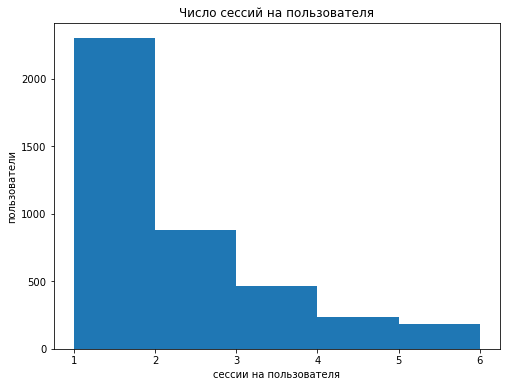

In [21]:
# Среднее и медианное число сессий на пользователя
report = df.groupby('user_id').agg({'session': 'nunique'})
print(
    'Среднее число сессий на пользователя:',
    round(report['session'].mean(), 1),
    '\nМедианное число сессий на пользователя:',
    report['session'].median()
)

# Рассчитаем Q3 и IQR для построения графика без выбросов
q1 = report['session'].quantile(0.25) # первый квартиль Q1
q3 = report['session'].quantile(0.75) # третий квартиль Q3
iqr = q3 - q1 # межквартильный размах IQR

# График распределения числа сессий на пользователя
report.plot(
    kind='hist',
    bins=5,
    range=(1, (q3 + 1.5 * iqr)),
    figsize=(8, 6),
    legend=False
)
plt.title('Число сессий на пользователя')
plt.xlabel('сессии на пользователя')
plt.ylabel('пользователи')
plt.show()

В среднем на одного пользователя приходится 2 сессии, но медианное значение — 1 сессия на пользователя. Среднее значение больше медианы из-за длинного хвоста редких, но очень высоких значений. Судя по гистограмме, большинство пользователей действительно имели по 1 сессии и больше в приложение не возвращались.

### Пользовательские профили
Для последующего расчета конверсии и retention rate получим пользовательские профили — список уникальных пользователей с данными о дате первого посещения и источнике привлечения пользователя.

In [22]:
# Получаем пользовательские профили
profiles = (
    df.groupby('user_id')
    .agg({'event_time': 'min', 'source': 'first'})
    .rename(columns={'event_time': 'first_ts'})
    .reset_index()
)

# Выделяем день первого посещения
profiles['first_dt'] = profiles['first_ts'].dt.date

# Проверяем полученные профили
profiles.head()

,user_id,first_ts,source,first_dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25


Пользовательские профили сформированы.

### DAU
Рассчитаем и визуализируем метрику DAU.

Средний DAU: 279.2


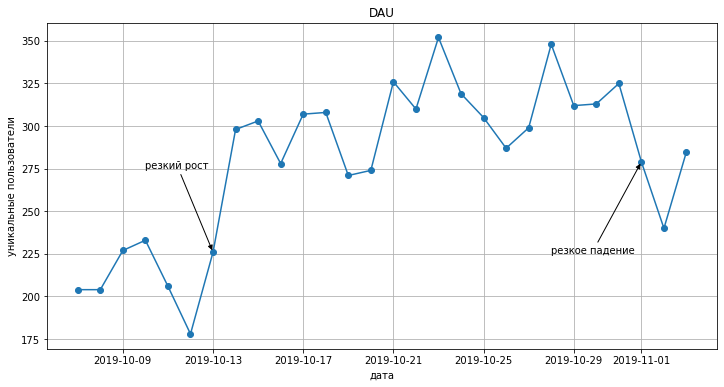

In [23]:
# Рассчитаем DAU
report = df.groupby('event_date').agg({'user_id': 'nunique'})

# Рассчитаем средний DAU
print(
    'Средний DAU:',
    round(report['user_id'].mean(), 1)
)

# Построим график DAU
report.plot(figsize=(12, 6), grid=True, marker='o', legend=False)
plt.title('DAU')
plt.xlabel('дата')
plt.ylabel('уникальные пользователи')
plt.annotate(
    'резкий рост',
    xy=('2019-10-13', 226),
    xytext=('2019-10-10', 275),
    arrowprops=dict(arrowstyle='-|>', facecolor='black')
)
plt.annotate(
    'резкое падение',
    xy=('2019-11-01', 279),
    xytext=('2019-10-28', 225),
    arrowprops=dict(arrowstyle='-|>', facecolor='black')
)
plt.show()

Средний DAU составляет 279 уникальных пользователей.

Минимальное значение DAU (178 пользователей) зафиксировано 12.10.2019, затем на графике отмечается резкий рост. До 31.10.2019 наблюдается растущий тренд, после этой даты — резкое снижение DAU.

### Retention
Рассчитаем retention rate.

In [24]:
#Получаем список пользовательских сессий
sessions = (
    df
    .groupby(['user_id', 'session'])
    .agg({'event_time': 'min'})
    .rename(columns={'event_time': 'session_start'})
    .reset_index()
)

# Проверяем список сессий
sessions.head()

,user_id,session,session_start
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45.989359
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:33:55.577963
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:52:30.778932
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,2019-10-22 11:18:14.635436
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,2019-10-19 21:34:33.849769


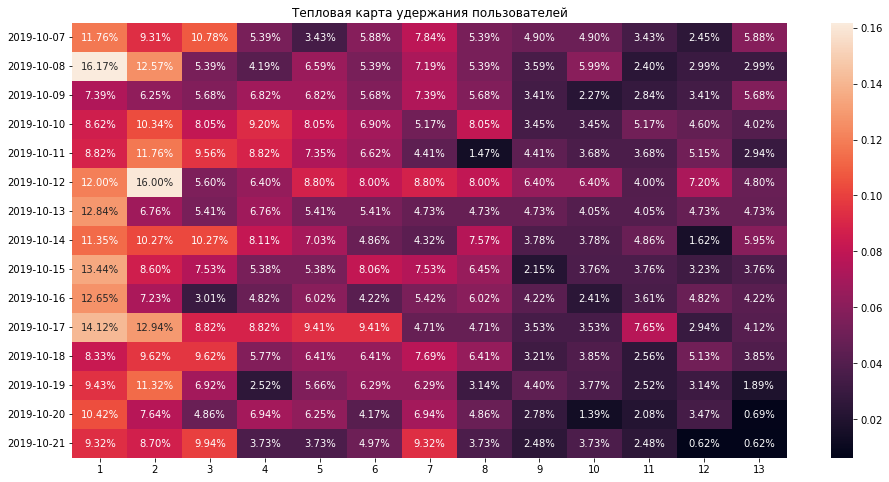

In [25]:
# Задаем максимальную дату привлечения
max_acquisition_date = dt.datetime(2019, 10, 21).date()

# Задаем максимальный лайфтайм для графика
max_lifetime = 14

# Добавляем в профили данные session_start из сессий
# с учетотом максимальной даты привлечения
result_raw = (
    profiles
    .query('first_dt <= @max_acquisition_date')
    .merge(
        sessions[['user_id', 'session_start']],
        on='user_id',
        how='left'
    )
)

# Добавляем лайфтайм для сессий в днях
result_raw['lifetime'] = (
    (result_raw['session_start']
     - result_raw['first_ts']).dt.days
)

# Строим таблицу удержания
result_grouped = (
    result_raw
    .pivot_table(
        index='first_dt',
        columns='lifetime',
        values='user_id',
        aggfunc='nunique'
    )
)

# Вычисляем размеры когорт
cohort_sizes = (
    result_raw
    .groupby('first_dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

# Объединяем размеры когорт и таблицу удержания
result_grouped = (
    cohort_sizes
    .merge(result_grouped, on='first_dt', how='left')
    .fillna(0)
)

# Делим данные таблицы удержания на размеры когорт
result_grouped = (
    result_grouped.div(result_grouped['cohort_size'], axis=0)
)

# Учитываем выбранный максимальный лайфтайм
result_grouped = (
    result_grouped[['cohort_size'] + list(range(max_lifetime))]
)

# Строим хитмэп удержания пользователей
plt.figure(figsize=(16, 8))
sns.heatmap(
    result_grouped.drop(columns=['cohort_size', 0]),
    annot=True,
    fmt='.2%'
)
plt.title('Тепловая карта удержания пользователей')
plt.ylabel('')
plt.show()

Тепловая карта показывает удержание пользователей до 14-го лайфтайма. Поэтому выбраны пользователи, привлеченные с 7 по 21 октября 2019 года, для которых есть полные данные по активности за 2 недели.

На 2-й лайфтайм в мобильное приложение возвращается от 7,4 до 16% пользователей. Максимальный retention 2-го дня у когорты, привлеченной 8 октября. В среднем теряются 89% пользователей.

На 14-й лайфтайм в мобильное приложение возвращается от 0,6 до 6% пользователей. Максимальный retention 14-го дня у когорты, привлеченной 14 октября. В среднем теряются 96% пользователей.

### Конверсия
Рассчитаем конверсию в целевое событие *contacts_show*.

In [26]:
# Добавим в датафрейм столбец conversion,
# отмечающий является ли событие целевым
df['conversion'] = df['event_name'] == 'contacts_show'
df

# Пользователи, совершившие конверсионное событие
conversion = df.groupby('user_id').agg({'conversion': 'max'})

# Конверсия
round(conversion.mean(), 2)

conversion    0.23
dtype: float64

Конверсия в целевое событие *contacts_show* составила 23%.

**Вывод**
<div style="background-color: #FBD603; width: 48px; height: 5px">&nbsp;</div>

В датасете представлены данные о событиях за период с 7 октября 2019 по 3 ноября 2019 для **4293 уникальных пользователей**.

Медианное **число событий на одного уникального пользователя — 9**.

Наиболее частыми являются tips_show (увидел рекомендованные объявления), photos_show (просмотрел фотографий в объявлении), search (действия, связанные с поиском по сайту), advert_open (открыл карточки объявления), contacts_show (посмотрел номер телефона) и map (открыл карту объявлений).

Наибольшее число событий обычно совершаются в понедельник и вторник, к выходным активность пользователей снижается

Выделено **10 368 пользовательских сессий**, сформированы пользовательские профили.

Средний **DAU** составляет **279 уникальных пользователей**.

Средний **retention rate** 2-го дня составляет **11%**, 14-го дня — **4%**.

**Конверсия** в целевое событие *contacts_show* составила **23%**.

## Анализ влияния событий на совершение целевого события
Выделим события, которые часто совершают пользователи вместе с целевым событием. Проанализируем, часто ли эти события бывают самостоятельными событиями пользователя или они составляют воронку. Проанализируем, за какое время до совершения целевого события совершаются вспомогательные события.

### Вспомогательные события
Найдем события, которые часто совершают пользователи вместе с целевым событием *contacts_show*.

In [27]:
# Получаем сессии, в которых совершено целевое событие
conv_sessions = (
    df
    .groupby('session')
    .agg({'conversion': 'max'})
)
conv_sessions = (
    conv_sessions
    .query('conversion == True')
    .index
    .to_list()
)

# Считаем события только для конверсионных сессий
df.query('session in @conv_sessions')['event_name'].value_counts()

tips_show        7509
contacts_show    4529
photos_show      1594
search            908
advert_open       777
contacts_call     541
map               514
favorites_add     251
tips_click        189
Name: event_name, dtype: int64

Вместе с целевым дейтвием *contacts_show* часто совершаются действия *tips_show*, *photos_show*, *search*, *advert_open*, *contacts_call*, *map*.

### Воронка событий
Определим, составляют ли вспомогательные события воронку, которая заканчивается целевым событием *contacts_show*.

Событие *tips_show* является событием по умолчанию, поэтому его и относящееся к нему событие *tips_click* не следует рассматривать в качестве вспомогательного. Событие *contacts_call* следует за *contacts_show*, поэтому также не может рассматриваться как вспомогательное.

Тогда вспомогательными будем считать частые события *photos_show*, *search*, *advert_open*, *map*.

Для получения списков первых и всех событий и их частотности для пользователей, совершивших вспомогательные события, определим функцию.

In [28]:
# Определяем функцию для получения топа первых
# событий и топа всех событий
def get_event_counts(event):
    '''
    Принимает событие, фильтрует пользователей,
    совершавших событие, возвращает топ первых
    событий и топ всех событий этих пользователей.
    
    '''
    # Фильтруем пользователей, совершавших событие
    event_users = (
        df
        .loc[df['event_name'] == event, 'user_id']
        .unique()
    )
    # Первые события сессий, совершенных пользователями
    print(
        df
        .query('user_id in @event_users')
        .groupby('session')
        .agg({'event_name': 'first'})['event_name']
        .value_counts()
    )
    # Все события, совершенные пользователями
    print()
    print(
        df
        .query('user_id in @event_users')['event_name']
        .value_counts()
    )

Воспользуемся функцией *get_event_counts* для получения событий пользователей, совершивших вспомогательные события *photos_show*, *search*, *advert_open*, *map*.

In [29]:
# Список вспомогательных событий
event_list = ['photos_show', 'search', 'advert_open', 'map']

# В цикле вызовем функцию get_event_counts
for event in event_list:
    print(
        'Списки событий пользователей,\nсовершавших событие',
        event,
        '\n'
    )
    get_event_counts(event)
    print()

Списки событий пользователей,
совершавших событие photos_show 

photos_show      1673
search           1161
contacts_show     242
advert_open        93
favorites_add      69
tips_show          16
map                 5
tips_click          1
Name: event_name, dtype: int64

photos_show      10012
search            2837
contacts_show     1089
favorites_add      673
advert_open        407
contacts_call      404
tips_show          231
map                 37
tips_click           8
Name: event_name, dtype: int64

Списки событий пользователей,
совершавших событие search 

search           2499
tips_show         756
photos_show       644
map               303
advert_open       183
contacts_show     168
favorites_add      51
tips_click          5
Name: event_name, dtype: int64

tips_show        13329
search            6784
photos_show       5808
advert_open       3253
contacts_show     1633
map               1547
favorites_add      853
contacts_call      266
tips_click         152
Name: event_nam

Пользователи, совершавшие событие *photos_show*, преимущественно начинают сессии с событий *photos_show* и *search*.

Пользователи, совершавшие событие *search*, преимущественно начинают сессии с событий *search* и *photos_show*. Часто встречается событие *advert_open*, которого почти нет в списке первых событий сессии.

Пользователи, совершавшие событие *advert_open*, преимущественно начинают сессии с событий *map*, *search*, *advert_open*. Часто встречается событие *advert_open*.

Пользователи, совершавшие событие *map*, преимущественно начинают сессии с событий *map*, *search*. Часто встречается событие *advert_open*.

Исходя из полученных выше данных, можно представить 3 частые воронки событий (в скобках отмечено необязательное событие):

1. photos_show → search → (advert_open) → contacts_show
2. search → photos_show → (advert_open) → contacts_show
3. map → advert_open → (photos_show) → contacts_show

### Временной интервал вспомогательных событий
Исследуем, за какое время до совершения целевого события совершаются вспомогательные события.

In [30]:
# Список вспомогательных и целового событий
event_list = ['photos_show', 'search', 'advert_open', 'map', 'contacts_show']

# Отфильтровываем события по списку
# и считаем разницу во времени между событиями
events = df.query('event_name in @event_list').reset_index()
events['time_diff'] = events['event_time'].diff()

# Список для хранения разницы во времени
time_diff = []

# Заполняем список
for i in range(len(events)):
    # Ищем строки с целевым событием
    if events['event_name'][i] == event_list[4]:
        # Проверяем, что предыдущая строка относится
        # к той же сессии и событие одно из вспомогательных
        if (
            events['event_name'][i - 1] not in event_list[4]
        ) and (
            events['session'][i] == events['session'][i - 1]
        ):
            # Добавляем разницу во времени в список
            time_diff.append(events['time_diff'][i])

# Считаем время между вспомогательны и целевым событиями,
# из списка интервалов делаем датафрейм, делим значения
# на секунды для длины интервала в секундах, выводим describe
(
    pd.DataFrame(time_diff)
    / dt.timedelta(seconds=1)
).describe()

,0
count,981.000000
mean,265.513162
std,478.485251
min,1.896557
25%,41.719908
50%,101.847629
75%,278.503005
max,7120.331925


В среднем вспомогательные события совершаются за 4 минуты и 27 секунд до совершения целевого события, медианное значение показателя — 1 минута и 42 секунды. На среднее значение сильно влияют выбросы (очень большие интервалы).

**Вывод**
<div style="background-color: #FBD603; width: 48px; height: 5px">&nbsp;</div>

Вместе с целевым событием *contacts_show* совершаются события *tips_show*, *photos_show*, *search*, *advert_open*, *contacts_call*, *map*.

Вспомогательные события составляют **3 воронки событий** (в скобках отмечено необязательное событие):

* photos_show → search → (advert_open) → contacts_show
* search → photos_show → (advert_open) → contacts_show
* map → advert_open → (photos_show) → contacts_show

Медианный **интервал между вспомогательным и целевым событиями составил 1 мин 42 с**.

## Статистический анализ данных

Проверим гипотезы:
* Конверсия различается в зависимости от событий.
* Конверсия различается в зависимости от источника.

### Проверка гипотезы о различии конверсии в зависимости от событий

Сформулируем нулевую гипотезу: *конверсия в просмотры контактов пользователей, которые совершают действия tips_show и tips_click, и тех, которые совершают только действие tips_show одинакова*.

Сформулируем альтернативную гипотезу: *конверсия в просмотры контактов пользователей, которые совершают действия tips_show и tips_click, и тех, которые совершают только действие tips_show различается*.

Определим критический уровень статистической значимости alpha в 5%. Для того, чтобы проверить, есть ли различия в конверсии между группами в зависимости от событий, проведем z-тест для пропорций.

Для проверки гипотезы определим функцию *check_hypothesis*.

In [31]:
# Определим функцию для проверки гипотезы
def check_hypothesis(successes_1, successes_2, trials_1, trials_2):
    '''
    Получает количество сконвертировавшихся
    и уникальных пользователей в двух группах.
    Возвращает p-value z-теста для пропорций.
    '''
    # пропорция успехов в первой группе
    p1 = successes_1 / trials_1
    # пропорция успехов во второй группе
    p2 = successes_2 / trials_2
    # пропорция успехов в комбинированном датасете
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials_1 + 1 / trials_2)
    )
    # задаем стандартное нормальное распределение
    distr = st.norm(0, 1)
    # получаем p_value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

Разделим пользователей на 2 группы:

* **группа A**, пользователи совершают действия *tips_show* и *tips_click*
* **группа B**, пользователи совершают только действие *tips_show*.

In [32]:
# Отфильтруем пользователей, совершавших
# события tips_show и tips_click
report = (
    df
    .groupby(['user_id', 'event_name'])
    .agg({'session': 'count'})
    .reset_index()
)
report = (
    report
    .query('event_name == "tips_show" | event_name == "tips_click"')
)

# Получим user_id пользователей двух групп
group_a_users = (
    report
    .query('event_name == "tips_click"')['user_id']
)
group_b_users = (
    report
    .query('user_id not in @group_a_users')['user_id']
)

# Считаем сконвертировавшихся пользователей в группах
group_a_conv = (
    conversion
    .query('user_id in @group_a_users')['conversion']
    .sum()
)
group_b_conv = (
    conversion
    .query('user_id in @group_b_users')['conversion']
    .sum()
)

# Выводим конверсию в группах
print(
    'Конверсия группы A:',
    round(group_a_conv / len(group_a_users), 2),
    '\nКонверсия группы B:',
    round(group_b_conv / len(group_b_users), 2))

Конверсия группы A: 0.31 
Конверсия группы B: 0.17


Проводим статистический тест.

In [33]:
# Критический уровень статистической значимости
alpha = 0.05

p_value = check_hypothesis(
    group_a_conv,
    group_b_conv,
    len(group_a_users),
    len(group_b_users)
)

print('p-value', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: конверсия различается в зависимости от событий.\n')
else:
    print('Не удалось отвергнуть нулевую гипотезу, конверсия одинакова вне зависимости от событий.\n')

p-value 9.576128778832071e-10
Отвергаем нулевую гипотезу: конверсия различается в зависимости от событий.



Статистический тест показал значимое различие в конверсии между пользователями *группы A* и *группы B*.

Таким образом, принимаем альтернативную гипотезу: *конверсия в просмотры контактов пользователей, которые совершают действия tips_show и tips_click, и тех, которые совершают только действие tips_show различается*.

### Проверка гипотезы о различии конверсии в зависимости от источника

Сформулируем нулевую гипотезу: *конверсия в просмотры контактов одинакова вне зависимости от источника*.

Сформулируем альтернативную гипотезу: *конверсия в просмотры контактов различается в зависимости от источника*.

Определим критический уровень статистической значимости alpha в 5%. Для того, чтобы проверить, есть ли различия в конверсии между группами по источнику привлечения, проведем z-тест для пропорций. Проводится 3 попарных сравнения:

* google и other
* google и yandex
* yandex и other 

Поэтому установим более строгий критический уровень статистической значимости, воспользовавшись поправкой Бонферрони (поправкой на множественное сравнение). Значение поправки — 3.

Воспользуемся созданной функцией *check_hypothesis* для проверки гипотезы.

In [34]:
# Разбиваем пользователей на группы
# и считаем сконвертировавшихся пользователей
report = conversion.merge(sourсes, on='user_id', how='left')
report = (
    report
    .pivot_table(
        index='source',
        columns='conversion',
        values='user_id',
        aggfunc='count'
    )
)
report = (
    report
    .rename(columns={False: 'not_conv', True: 'conv'})
)
report['users'] = report['not_conv'] + report['conv']
report['conversion'] = round(report['conv'] / report['users'], 2)
report

conversion,not_conv,conv,users,conversion
source,,,,
google,854,275,1129,0.24
other,1002,228,1230,0.19
yandex,1456,478,1934,0.25


Проводим статистический тест.

In [35]:
# Критический уровень статистической значимости
# с учетом поправки на множественное сравнение
alpha = 0.05 / 3

for source_1 in report.index:
    for source_2 in report.index:
        if source_1 == source_2:
            break
        else:
            p_value = check_hypothesis(
                report['conv'][source_1],
                report['conv'][source_2],
                report['users'][source_1],
                report['users'][source_2])
            print(source_1, '/', source_2, '— p-value', p_value)
            if p_value < alpha:
                print('Отвергаем нулевую гипотезу: конверсия в просмотры контактов различается.\n')
            else:
                print('Не удалось отвергнуть нулевую гипотезу, конверсия в просмотры контактов одинакова.\n')

other / google — p-value 0.0005640941887214979
Отвергаем нулевую гипотезу: конверсия в просмотры контактов различается.

yandex / google — p-value 0.8244316027993777
Не удалось отвергнуть нулевую гипотезу, конверсия в просмотры контактов одинакова.

yandex / other — p-value 4.7142597613403225e-05
Отвергаем нулевую гипотезу: конверсия в просмотры контактов различается.



Статистический тест показал значимое различие в конверсии между группами пользователей, привлеченных из источников *google и other*, а также из *yandex и other*.

Различие в конверсии между группами пользователей, привлеченных из источников *google и yandex* не является статистически достоверным.

Таким образом, принимаем альтернативную гипотезу: *конверсия в просмотры контактов различается в зависимости от источника*.

**Вывод**
<div style="background-color: #FBD603; width: 48px; height: 5px">&nbsp;</div>

Проверка гипотезы о различии конверсии в зависимости от событий показала, что *конверсия в просмотры контактов пользователей, которые совершают действия tips_show и tips_click, и тех, которые совершают только действие tips_show различается*. Конверсия в целевое событие *contacts_show* составляет:

* **31%** в группе пользователей, которые совершают действия *tips_show* и *tips_click*.
* **17%** в группе пользователей, которые совершают только действие *tips_show*.

Проверка гипотезы о различии конверсии в зависимости от источника показала, что *конверсия в просмотры контактов различается в зависимости от источника*. Различие в конверсии между группами пользователей, привлеченных из источников google и yandex не является статистически достоверным. Конверсия в целевое событие contacts_show составляет:

* **25%** в группе пользователей, привлеченных из Яндекса.
* **24%** в группе пользователей, привлеченных из Google.
* **19%** в группе пользователей, привлеченных из других источников.

## Выводы

На этапе предобработки данных мы исправили стиль заголовков и тип данных столбца event_time, исходные данные были объединены в один датафрейм. Мы обнаружили аномалию в данных — дубликаты, возникающие при округлении времени события до миллисекунд и секунд. Не имея дополнительной информации о регистрации событий, невозможно однозначно утверждать, является ли она ошибкой в данных.

На этапе исследовательского анализа данных мы изучили бизнес-показатели мобильного приложения:
* Медианное **число событий на одного уникального пользователя — 9**.
* Средний **DAU** составляет **279 уникальных пользователей**.
* Средний **retention rate** 2-го дня составляет **11%**, 14-го дня — **4%**.
* **Конверсия** в целевое событие *contacts_show* составила **23%**.

На этапе анализа влияния событий на совершение целевого события обнаружено:
* Вместе с целевым событием *contacts_show* совершаются события *tips_show*, *photos_show*, *search*, *advert_open*, *contacts_call*, *map*.
* Вспомогательные события составляют 3 частые воронки событий (в скобках отмечено необязательное событие):
    * photos_show → search → (advert_open) → contacts_show
    * search → photos_show → (advert_open) → contacts_show
    * map → advert_open → (photos_show) → contacts_show
* Медианный интервал между вспомогательным и целевым событиями составил 1 мин 42 с.

Проверка гипотез с помощью статистического теста показала:
* Конверсия в просмотры контактов пользователей, которые совершают действия tips_show и tips_click, и тех, которые совершают только действие tips_show различается.
* Конверсия в просмотры контактов различается в зависимости от источника. Различие в конверсии между группами пользователей, привлеченных из источников google и yandex не является статистически достоверным.

Рекомендации по результатам исследования:
* Retention rate показывает, что большинство пользователей не возвращаются в приложение. Можно порекомендовать **рассчитать retention на более длительном периоде**. Возможно, имея положительный опыт покупки в приложении, пользователь снова вернется, когда у него появятся ненужные вещи.
* Просмотр фотографий — самое частое пользовательское событие. Следует **мотивировать пользователей размещать больше фотографий** вещей, это способствует продажам.
* Следует **улучшать рекомендательную систему** — пользователи, кликнувшие по рекомендованному объявлению, существенно более конверсионные. Однако конверсия в клик по рекомендованному объявлению низкая.
* Следует **привлекать больше трафика из поисковых систем Яндекса и Google**, который является наиболее конверсионным. Также необходимо проверить трафик с пометкой *other*, возможно, удастся найти конкретные каналы, снижающие конверсию в этой группе источников.